<a href="https://colab.research.google.com/github/sebastianTech/Text-classification/blob/master/Text_Classification_with_News_Article_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install altair vega_datasets

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.naive_bayes import GaussianNB


# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
giantstride = pd.read_csv("/content/drive/My Drive/Task/final_dataset_basicmlmodel.csv", header=0,encoding= 'unicode_escape')

In [ ]:
giantstride.head()


,TITLE,Human,Label
0,Corona: Virologists Are Divided Over Need for ...,Risk,8
1,Snapchat?s new lenses use AR to encourage soci...,Covid,0
2,Corona Challenge: Germany Reaching the Upper L...,Risk,8
3,Should You Worry About Eni S.p.A.'s (BIT:ENI) ...,Organizational Change,3
4,The crown vs. corona,General,1


In [ ]:
for index, TITLE in enumerate(giantstride["TITLE"][10:15]):
    print(index+1,".",TITLE)

1 . Innovations in times of Covid19
2 . Vettel: Happiness, not money, key to new Ferrari F1 deal
3 . You'll love this high tech water bottle, which just went on sale
4 . Late 2020 Thailand beach hopper from Amsterdam for ?393! Discover Phuket, Koh Samui, Krabi and Phi Phi Islands!
5 . This Browser Tool Makes Creating Gifs Easy for People Who Love Minimal Effort


In [ ]:
! pip install altair vega_datasets

In [ ]:
bars = alt.Chart(giantstride).mark_bar(size=50).encode(
    x=alt.X("Human"),
    y=alt.Y("count():Q", axis=alt.Axis(title='Number of articles')),
    tooltip=[alt.Tooltip('count()', title='Number of articles'), 'Human'],
    color='Human'

)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='count()'
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "Number of articles in each category",
)

alt.LayerChart(...)

In [ ]:
giantstride['News_length'] = giantstride['TITLE'].str.len()

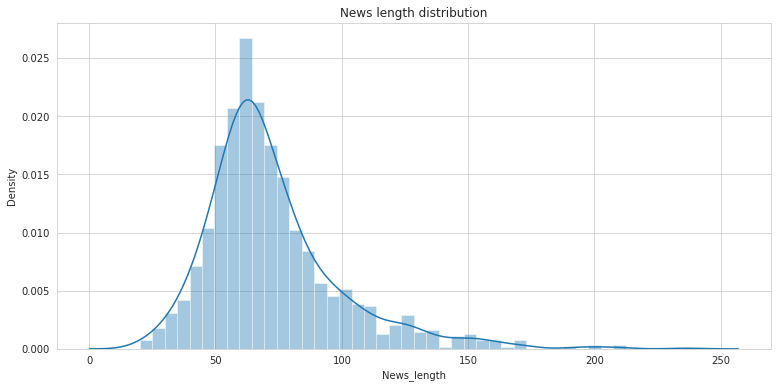

In [ ]:
plt.figure(figsize=(12.8,6))
sns.distplot(giantstride['News_length']).set_title('News length distribution');

In [ ]:
giantstride['News_length'].describe()

count    1109.000000
mean       72.513075
std        27.091986
min        20.000000
25%        56.000000
50%        66.000000
75%        82.000000
max       237.000000
Name: News_length, dtype: float64

In [ ]:
giantstride.loc[1]['TITLE']

'Snapchat?s new lenses use AR to encourage social distancing'

#Text Cleaning
We'll downcase the texts 

In [ ]:
# Lowercasing the text
giantstride['Content_Parsed_2'] = giantstride['TITLE'].str.lower()

# Punctuation signs

Punctuation signs won't have any predicting power, so we'll just get rid of them.


In [ ]:
punctuation_signs = list("?:!.,;")
giantstride['Content_Parsed_3'] = giantstride['Content_Parsed_2']

for punct_sign in punctuation_signs:
    giantstride['Content_Parsed_3'] = giantstride['Content_Parsed_3'].str.replace(punct_sign, '')


# Possessive pronouns

We'll also remove possessive pronoun terminations:


In [ ]:
giantstride['Content_Parsed_4'] = giantstride['Content_Parsed_3'].str.replace("'s", "")

## Stemming and Lemmatization

Since stemming can produce output words that don't exist, we'll only use a lemmatization process at this moment. Lemmatization takes into consideration the morphological analysis of the words and returns words that do exist, so it will be more useful for us.

In [ ]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
------------------------------------------------------------
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
nrows = len(giantstride)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = giantstride.loc[row]['Content_Parsed_4']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [ ]:
giantstride['Content_Parsed_5'] = lemmatized_text_list


In [ ]:
giantstride.head()

,TITLE,Human,Label,News_length,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5
0,Corona: Virologists Are Divided Over Need for ...,Risk,8,65,corona: virologists are divided over need for ...,corona virologists are divided over need for d...,corona virologists are divided over need for d...,corona virologists be divide over need for dra...
1,Snapchat?s new lenses use AR to encourage soci...,Covid,0,59,snapchat?s new lenses use ar to encourage soci...,snapchats new lenses use ar to encourage socia...,snapchats new lenses use ar to encourage socia...,snapchats new lenses use ar to encourage socia...
2,Corona Challenge: Germany Reaching the Upper L...,Risk,8,70,corona challenge: germany reaching the upper l...,corona challenge germany reaching the upper li...,corona challenge germany reaching the upper li...,corona challenge germany reach the upper limit...
3,Should You Worry About Eni S.p.A.'s (BIT:ENI) ...,Organizational Change,3,54,should you worry about eni s.p.a.'s (bit:eni) ...,should you worry about eni spa's (biteni) ceo pay,should you worry about eni spa (biteni) ceo pay,should you worry about eni spa (biteni) ceo pay
4,The crown vs. corona,General,1,20,the crown vs. corona,the crown vs corona,the crown vs corona,the crown vs corona


In [ ]:
giantstride = giantstride.rename(columns={'Content_Parsed_5': 'Content_Parsed'})

In [ ]:
category_codes = {
    'Covid': 0,
    'General': 1,
    'Opportunity': 2,
    'organizational Change': 3,
    'Press Release': 4,
    'Profit warning': 5,
    'Revenue growth': 6,
    'Revenue warning': 7,
    'Risk': 8

}

In [ ]:
# Category mapping
giantstride['Category_Code'] = giantstride['Human']
giantstride = giantstride.replace({'Category_Code':category_codes})

In [ ]:
giantstride.head(10)

,TITLE,Human,Label,News_length,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed,Category_Code
0,Corona: Virologists Are Divided Over Need for ...,Risk,8,65,corona: virologists are divided over need for ...,corona virologists are divided over need for d...,corona virologists are divided over need for d...,corona virologists be divide over need for dra...,8
1,Snapchat?s new lenses use AR to encourage soci...,Covid,0,59,snapchat?s new lenses use ar to encourage soci...,snapchats new lenses use ar to encourage socia...,snapchats new lenses use ar to encourage socia...,snapchats new lenses use ar to encourage socia...,0
2,Corona Challenge: Germany Reaching the Upper L...,Risk,8,70,corona challenge: germany reaching the upper l...,corona challenge germany reaching the upper li...,corona challenge germany reaching the upper li...,corona challenge germany reach the upper limit...,8
3,Should You Worry About Eni S.p.A.'s (BIT:ENI) ...,Organizational Change,3,54,should you worry about eni s.p.a.'s (bit:eni) ...,should you worry about eni spa's (biteni) ceo pay,should you worry about eni spa (biteni) ceo pay,should you worry about eni spa (biteni) ceo pay,Organizational Change
4,The crown vs. corona,General,1,20,the crown vs. corona,the crown vs corona,the crown vs corona,the crown vs corona,1
5,Follow the hot hands': HSBC lays out a coronav...,Opportunity,2,160,follow the hot hands': hsbc lays out a coronav...,follow the hot hands' hsbc lays out a coronavi...,follow the hot hands' hsbc lays out a coronavi...,follow the hot hands' hsbc lay out a coronavir...,2
6,"Welcome to the telco, we've got fun and games:...",Opportunity,2,107,"welcome to the telco, we've got fun and games:...",welcome to the telco we've got fun and games b...,welcome to the telco we've got fun and games b...,welcome to the telco we've get fun and game bt...,2
7,Social distancing is pushing esports into the ...,General,1,56,social distancing is pushing esports into the ...,social distancing is pushing esports into the ...,social distancing is pushing esports into the ...,social distance be push esports into the mains...,1
8,1966 Ferrari 275 GTS,General,1,20,1966 ferrari 275 gts,1966 ferrari 275 gts,1966 ferrari 275 gts,1966 ferrari 275 gts,1
9,Tom Brady shows Chris Godwin love on Instagram...,General,1,58,tom brady shows chris godwin love on instagram...,tom brady shows chris godwin love on instagram...,tom brady shows chris godwin love on instagram...,tom brady show chris godwin love on instagram ...,1


## Train - test split

I will set apart a test set to prove the quality of our models. I will do Cross Validation in the train set in order to tune the hyperparameters and then test performance on the unseen data of the test set.


In [ ]:
giantstride.dtypes

TITLE               object
Human               object
Label                int64
News_length          int64
Content_Parsed_2    object
Content_Parsed_3    object
Content_Parsed_4    object
Content_Parsed      object
Category_Code       object
dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(giantstride['Content_Parsed'], 
                                                    giantstride['Category_Code'], 
                                                    test_size=0.15, 
                                                    random_state=8)

In [ ]:
# Parameter election
ngram_range = (1,2)
min_df = 5
max_df = 1.
max_features = 300

In [ ]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(942, 300)
(167, 300)




Please note that we have fitted and then transformed the training set, but we have only transformed the test set.

We can use the Chi squared test in order to see what unigrams and bigrams are most correlated with each category:


In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'Covid' category:
  . Most correlated unigrams:
. crisis
. covid19
. coronavirus
. 19
. covid
  . Most correlated bigrams:
. coronavirus crisis
. covid 19

# 'General' category:
  . Most correlated unigrams:
. russia
. profit
. covid
. 19
. coronavirus
  . Most correlated bigrams:
. set to
. covid 19

# 'Opportunity' category:
  . Most correlated unigrams:
. launch
. microsoft
. money
. facebook
. ai
  . Most correlated bigrams:
. set to
. mercedes benz

# 'Press Release' category:
  . Most correlated unigrams:
. investment
. chairman
. unicredit
. boost
. state
  . Most correlated bigrams:
. reuters uk
. bbc news

# 'Profit warning' category:
  . Most correlated unigrams:
. fincantieri
. file
. ferrari
. facebook
. zoom
  . Most correlated bigrams:
. in india
. donald trump

# 'Revenue growth' category:
  . Most correlated unigrams:
. fincantieri
. file
. ferrari
. facebook
. zoom
  . Most correlated bigrams:
. in india
. donald trump

# 'Revenue warning' category:
  . Most correlat

In [ ]:
bigrams

['oil price',
 'of the',
 'philip morris',
 'plan to',
 'lloyds bank',
 'mercedes benz',
 'nmc health',
 'return to',
 'to take',
 'to help',
 'royal bank',
 'reuters uk',
 'reuters india',
 'set to',
 'sport direct',
 'social distance',
 'boris johnson',
 'covid 19',
 'coronavirus crisis',
 'be the',
 'bbc news',
 'bank of',
 'hong kong',
 'hedge fund',
 'in the',
 'in india',
 'donald trump']

In [ ]:
print(features_train.shape)
print(features_test.shape)

(942, 300)
(167, 300)


In [ ]:
from sklearn.naive_bayes import GaussianNB

#Initialize GaussianNB classifier
model = GaussianNB()
#Fit the model on the train dataset
model = model.fit(features_train, y_train)
#Make predictions on the test dataset
pred = model.predict(X_test)

TypeError: ignored